<a href="https://colab.research.google.com/github/yeshengw/robust-risk-aware-rl/blob/uploads/Example_3_Robust_Dynamic_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab/RRA_RL/ex4/"
save_dir = "/content/gdrive/My Drive/Colab/RRA_RL/ex4/save"
sys.path.append("/content/gdrive/My Drive/Colab/RRA_RL/")

Mounted at /content/gdrive


In [ ]:
from parameters import *
from market_models import *
from solution import *
from metrics import *
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import time

In [ ]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# Networks

In [ ]:
class InnerNet(nn.Module):

    def __init__(self, n_hidden):
        super(InnerNet, self).__init__()

        self.fc_inp_h1 = nn.Linear(1, n_hidden)
        self.fc_h1_h2 = nn.Linear(n_hidden, n_hidden)
        self.fc_h2_out = nn.Linear(n_hidden, 1)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        x = self.myReLU(self.fc_inp_h1(x))
        x = self.myReLU(self.fc_h1_h2(x))
        y = self.fc_h2_out(x)

        return y

class OuterNet(nn.Module):

    def __init__(self, n_feats, n_hidden, n_assets, invent_limit = 5):
        super(OuterNet, self).__init__()
        self.fc_inp_to_h1 = nn.Linear(n_feats, n_hidden)
        self.fc_h1_h2 = nn.Linear(n_hidden, n_hidden)
        self.fc_h2_out = nn.Linear(n_hidden, n_assets)
        self.invent_limit = invent_limit
        self.myReLU = nn.ReLU()

        self.mySoftmax = nn.Softmax(dim=2)
        # apply the softmax function along dim=2 (dimension of assets) (recall dim of state: (Ndt+1, Nsim, Nassets)
        # s.t. the weights of the assets sum to 1

    def forward(self, x):
        x = self.myReLU(self.fc_inp_to_h1(x))
        x = self.myReLU(self.fc_h1_h2(x))
        y = self.mySoftmax(self.fc_h2_out(x))

        return y

# Agents
#### Formula 2.3:    
$X^\varphi=-\sum^{T-1}_{i=0}\varphi_i S_i+q_T^\varphi S_T=\sum^T_{i=1}q_i^\varphi (S_i-S_{i-1})$

where $q_i^\varphi = \sum^{i-1}_{j=0} \varphi_j$ is the total shares of asset held at time $t_i$.

$daily~return_i  = \frac{1}{T}\frac{S_i - S_{i-1}}{S_{i-1}}$

$portfolio~daily~return_i = w_i \cdot daily~return_i$

$transaction~cost = \sum^{T-1}_{i=0}\varphi_i S_i \cdot transaction~cost~\%$



In [ ]:
class EOU_Agent(Agent):
  def __init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update = True):
    Agent.__init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update)
    Ndt, _, Nsims, Nassets, _, _, _ = self.sim_params.GetParams()

    self.X_phi_history = np.empty((Nsims, 0))

    self.wt_history = []
    self.daily_asset_value_history = []
    self.daily_phi_history = []

  def sim_phi(self):
    t, S = self.market_model.t, self.market_model.S
    Ndt, T, Nsims, Nassets, S0, _, _ = self.sim_params.GetParams()
            # Ndt=252, T=1, Nsim=6k, Nassets, S0=array([1])
    initial_capital = 10  # initial portfolio capital
    daily_phi_limit = torch.tensor(10).to(device)  # the agent can buy/sell at most 10 shares of an asset in a single trade day

    # S_t has dimensions time, number of simulations, number of assets
    S_t = torch.FloatTensor(S).to(device)
    # asset price change every dt
    # dimension: Ndt, Nsims, Nassets
    S_dt = S_t[1:, :, :] - S_t[:-1, :, :]

    # construct state tensor consisting of time and scaled asset price
    state = torch.zeros((Ndt + 1, Nsims, Nassets + 1)).to(device)
            # three dimensions: time, simulation runs, and 2 features
            # time feature, price feature

    state[:, :, 0] = torch.FloatTensor(t.reshape(-1,1) / t[-1]).to(device) # feature 1 normalized time between 0 and 1
    S0 = torch.FloatTensor(S0).to(device)
    # asset price scaled in terms of % difference from starting price multiplied by constant of 4 to ensure magnitude is not too small
    for i in range(Nassets):
        state[:, :, i+1] = (S_t[:,:,i] - S0) / S0 * 4 # feature 2 scaled price
    """
    S_t[trading day index, iteration index, asset index]
    original: state[:, :, 1] = (S_t[:, :, 0] - S0[0]) / S0[0] * 4
    S_t[:, :, :]: price of all assets
    S0: 1-vector
    """

    # inventory// in example 4: allocation
    w_t = self.outer_net(state)  # w_t=[trade date, iteration index, asset index]

    # step 1
    daily_phi = torch.zeros((Ndt + 1, Nsims, Nassets)).to(device)
    daily_inventory = torch.zeros((Ndt + 1, Nsims, Nassets)).to(device)  # at day 0, all 0
    daily_asset_value = torch.zeros((Ndt + 1, Nsims, Nassets)).to(device)

    daily_phi_temp = initial_capital * w_t[0, :, :] / S_t[0, :, :]  # shares bought/buy (daily transactions)
    daily_phi[0, :, :] = torch.clip(daily_phi_temp, -daily_phi_limit, daily_phi_limit)  # cap daily transaction within +/- limit
    daily_inventory[0, :, :] = daily_phi[0, :, :]  # total number of shares held, after daily tractions
    daily_asset_value[0, :, :] = daily_inventory[0, :, :] * S_t[0, :, :]  # asset value after daily transactions

    for i in range(1, Ndt+1):
      temp_portfolio_value = torch.sum(S_t[i, :, :] * daily_inventory[i-1, :, :], axis=1)
      target_inventory = (w_t[i, :, :] * temp_portfolio_value[:, None]) / S_t[i, :, :]
      daily_phi_temp = target_inventory - daily_inventory[i-1, :, :]
      daily_phi[i, :, :] = torch.clip(daily_phi_temp, -daily_phi_limit, daily_phi_limit) # cap daily transaction within +/- limit
      daily_inventory[i, :, :] = daily_phi[i, :, :] + daily_inventory[i-1, :, :]
      daily_asset_value[i, :, :] = daily_inventory[i, :, :] * S_t[i, :, :]

    # other loss = transaction cost
    transaction_cost = 0.001
    self.other_loss = torch.mean(torch.sum(torch.abs(daily_phi) * S_t, axis=(0, 2))) * transaction_cost

    X_phi_T = torch.sum(daily_asset_value[-1, :, :], axis=1)

    X_phi_T_np = X_phi_T.cpu().detach().numpy().reshape(-1,1)
    """
    reshape() X_phi_T_np such that it becomes a (Nsim, 1) "matrix", and can concatenate with X_phi_history down the line.
    X_phi_history is of dim (Nsim, 0), we concatenate along axis = 1. X_phi_T_np and X_phi_history must of the same shape except in axis=1.
    """

    # initialize array of shares bought/sold at trading times
    phi_t_np = np.zeros((Ndt + 1, Nsims, Nassets))
    # trade size is difference in inventory (initial inventory of 0)

    self.X_phi_history = np.concatenate((self.X_phi_history, X_phi_T_np), axis = 1)


    wt_np = w_t.cpu().detach().numpy()
    self.wt_history.append(wt_np)
    if len(self.wt_history) > 5:
      self.wt_history.pop(0)

    dav_np = daily_asset_value.cpu().detach().numpy()
    self.daily_asset_value_history.append(dav_np)
    if len(self.daily_asset_value_history) > 5:
      self.daily_asset_value_history.pop(0)

    dp_np = daily_phi.cpu().detach().numpy()
    self.daily_phi_history.append(dp_np)
    if len(self.daily_phi_history) > 5:
      self.daily_phi_history.pop(0)

    return X_phi_T

  def PlotCustom(self, X, Y, adversary):
    print("Outer Problem Metrics")
    self.PlotStrategy()
    print("Inner Problem Metrics")
    adversary.PrintMetrics()
    adversary.PlotHistory()
    adversary.PlotDistortion(X, Y)


  def PlotStrategy(self):
    # plot heatmaps at four quartiles
    pass

"""
Plot
ToDO: plot_1: fix alpha, beta, adjust p
ToDO: plot_2: example 1 figure 2: asset allocation with difference p value (on x axis), portfolio weights (y axis)
"""

'\nPlot\nToDO: plot_1: fix alpha, beta, adjust p\nToDO: plot_2: example 1 figure 2: asset allocation with difference p value (on x axis), portfolio weights (y axis)\n'

In [ ]:
class OU_Adversary(Adversary):
  def __init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective = "maximize", reset_lm = True, reset_net = False):
    Adversary.__init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective, reset_lm, reset_net)

  def sim_theta(self, X_phi_T, market_model):
    X_theta_T = self.inner_net(X_phi_T)
    return X_theta_T



# Parameters

In [ ]:
sim_param_dict = {
               "Nassets" : 8,
               "Nsims" : 2000,
               "S0" : np.array([1]),
               "T" : 1,
               "Ndt" : 252
                }
# for higher Nsims, the density distribution between X_phi and X_theta would overlap more

EOU_param_dict = {
              "kappa" : np.array([5]),
               "sigma" : np.array([0.8]),
                 }

LM_param_dict = { "lam": 1,
                  "mu": 80,
                  "mu_update": 1.2,
                  "update_freq": 1000
                  }


wass_param_dict = {"wass_order" : 2,
                   "wass_limit" : 0.15
                  }

train_param_dict = {"inner_epochs" : 3000,
                    "outer_epochs" : 150,
                    "plot_freq_outer" : 10,
                    "plot_freq_inner" : np.inf,
                    "inner_lr": 1e-3,
                    "outer_lr": 2e-2,
                    "freeze_market_iter": 1,
                    "freeze_inner_iter" : 1
                   }

sim_params = Sim_Params(sim_param_dict)
market_params = MarketModel_Params(EOU_param_dict, Type = "EOU")
lm_params = LM_Params(LM_param_dict)
wass_params = Wass_Params(wass_param_dict)
train_params = Train_Params(train_param_dict)

In [ ]:
OU_model = Extended_Ornstein_Uhlenbeck(market_params)
OU_model.Sim(sim_params)
OU_model.PlotSim()

Output hidden; open in https://colab.research.google.com to view.

# Results

## $\alpha = 0.1, \beta = 0.9, p = 0.75$

In [ ]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0.75,
                  "rm_type" : 'alpha-beta'
                  }

rm_params = RM_Params(RM_param_dict)

In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(9, 10, 8).to(device) # change OuterNet(2, 10, 1) to OuterNet(9, 10, 8) stands for 8 assets as output
inner_name = root_dir + "inner_p_0.75"
outer_name = root_dir + "outer_p_0.75"

In [ ]:
agent = EOU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
agent.train(adversary)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.save(save_dir + "075/" + "wt_history.npy", agent.wt_history)
np.save(save_dir + "075/" + "daily_phi_history.npy", agent.daily_phi_history)
np.save(save_dir + "075/" + "daily_asset_value_history.npy", agent.daily_asset_value_history)
np.save(save_dir + "075/" + "x_phi.npy", agent.X_phi_history)

wt_history:
  - a list of w_t elements
  - length of the list: # outer epochs
  - each w_t element has a dimension of (Ndt+1, Nsims, Nassets)

daily_phi_history:
  - length: # outer epochs
  - daily_phi dimension: (Ndt+1, Nsims, Nassets)

daily_asset_value_history:
  - length: # outer epochs
  - daily_asset_value dimension: (Ndt+1, Nsims, Nassets)

X_phi_history
  - X_phi dimension: (Nsims, NouterEpochs)

[2.3895032e-07 4.4386007e-02 9.0471366e-03 1.8950228e-02 9.3863076e-03
 8.4340656e-03 3.5901922e-03 9.0620583e-01]


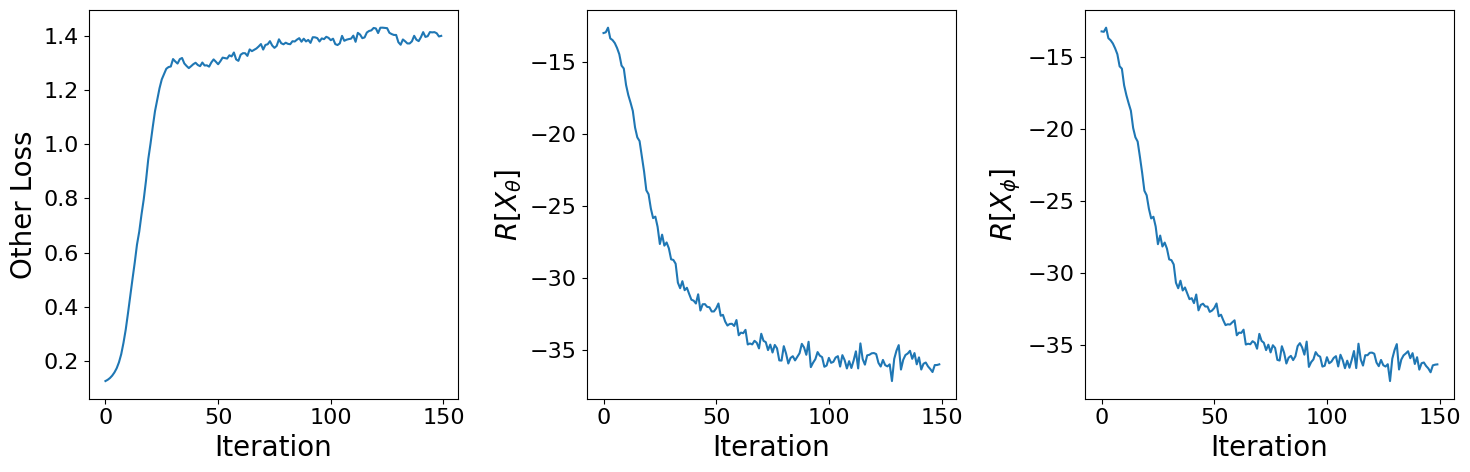

In [ ]:
wt = agent.wt_history[-1]
print(wt[-1, -1])
agent.PlotHistory()

## $\alpha = 0.1, \beta = 0.9, p = 0.9$

In [ ]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0.9,
                  "rm_type" : 'alpha-beta'
                  }

rm_params = RM_Params(RM_param_dict)

In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(9, 10, 8).to(device)
inner_name = root_dir + "inner_p_0.9"
outer_name = root_dir + "outer_p_0.9"

In [ ]:
agent = EOU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
agent.train(adversary)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.save(save_dir + "090/" + "wt_history.npy", agent.wt_history)
np.save(save_dir + "090/" + "daily_phi_history.npy", agent.daily_phi_history)
np.save(save_dir + "090/" + "daily_asset_value_history.npy", agent.daily_asset_value_history)
np.save(save_dir + "090/" + "x_phi.npy", agent.X_phi_history)

[0.09479088 0.0301333  0.10042882 0.3925326  0.08684142 0.12637417
 0.1289635  0.03993538]


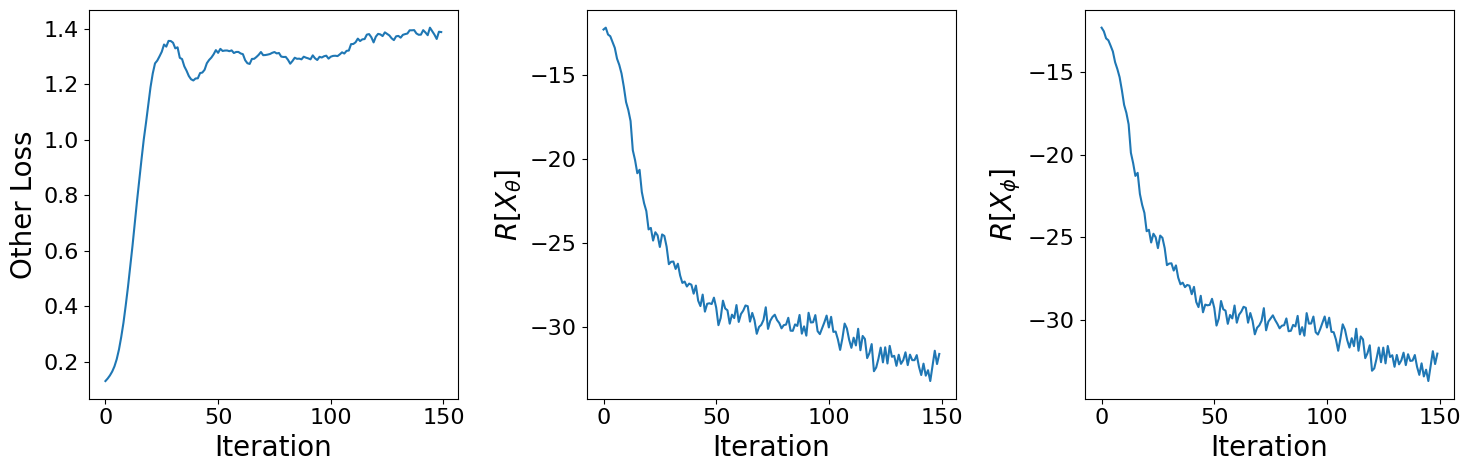

In [ ]:
wt = agent.wt_history[-1]
print(wt[-1, -1])
agent.PlotHistory()

## $\alpha = 0.1, \beta = 0.9, p = 1$

In [ ]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 1,
                  "rm_type" : 'alpha-beta'
                  }

rm_params = RM_Params(RM_param_dict)

In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(9, 10, 8).to(device)
inner_name = root_dir + "inner_p_1"
outer_name = root_dir + "outer_p_1"

In [ ]:
agent = EOU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
agent.train(adversary)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.save(save_dir + "100/" + "wt_history.npy", agent.wt_history)
np.save(save_dir + "100/" + "daily_phi_history.npy", agent.daily_phi_history)
np.save(save_dir + "100/" + "daily_asset_value_history.npy", agent.daily_asset_value_history)
np.save(save_dir + "100/" + "x_phi.npy", agent.X_phi_history)

[0.09295457 0.02647521 0.17749408 0.46189943 0.0460433  0.16442984
 0.00993938 0.02076422]


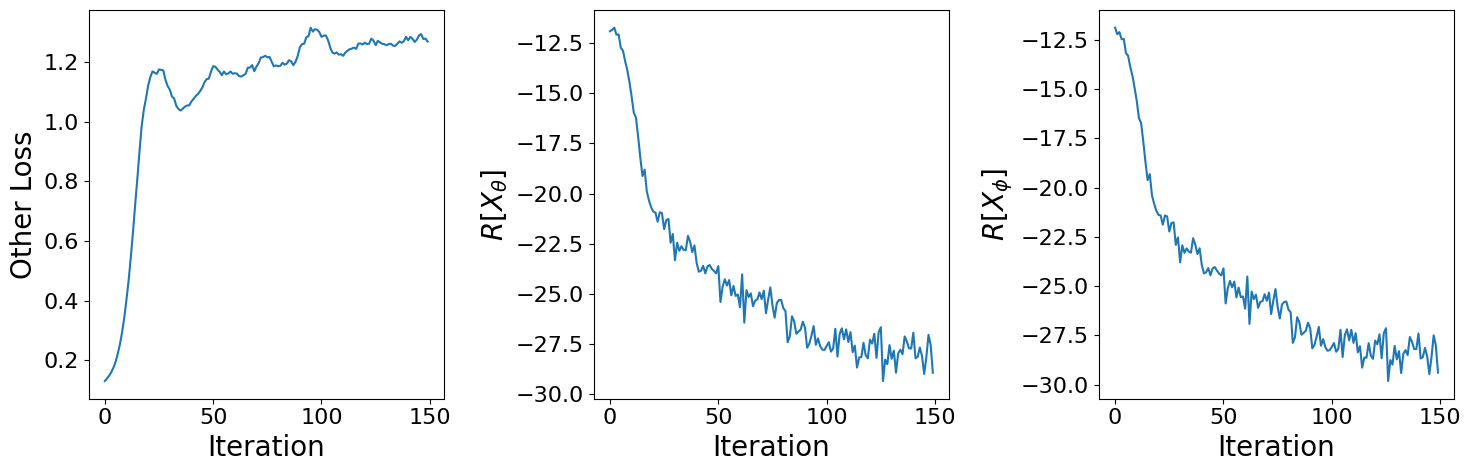

In [ ]:
wt = agent.wt_history[-1]
print(wt[-1, -1])
agent.PlotHistory()

## $\alpha = 0.1, \beta = 0.9, p = 0.5$



In [ ]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0.5,
                  "rm_type" : 'alpha-beta'
                  }

rm_params = RM_Params(RM_param_dict)

In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(9, 10, 8).to(device)
inner_name = root_dir + "inner_p_0.5"
outer_name = root_dir + "outer_p_0.5"

In [ ]:
agent = EOU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
start_time = time.time()
agent.train(adversary)
end_time = time.time()
elapsed_time = end_time - start_time

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.save(save_dir + "050/" + "wt_history050.npy", agent.wt_history)
np.save(save_dir + "050/" + "daily_phi_history050.npy", agent.daily_phi_history)
np.save(save_dir + "050/" + "daily_asset_value_history050.npy", agent.daily_asset_value_history)
np.save(save_dir + "050/" + "x_phi050.npy", agent.X_phi_history)

Elapsed Time: 3039.114843606949
[7.0682772e-02 1.0764713e-06 5.9302932e-01 3.0472899e-02 2.1583259e-02
 3.4537066e-02 1.2196572e-02 2.3749705e-01]


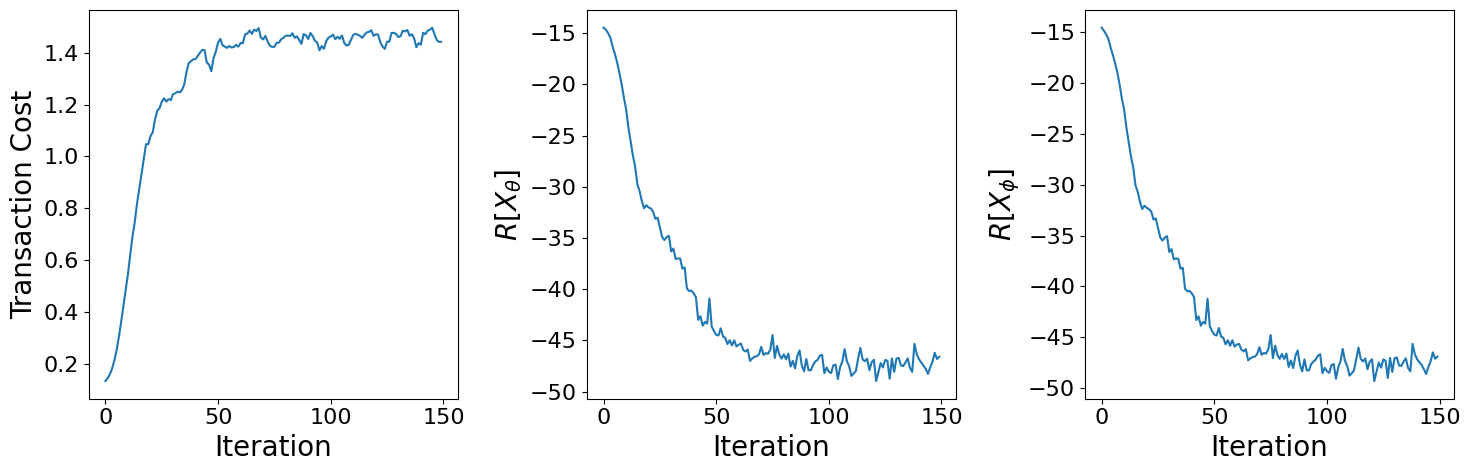

In [ ]:
print("Elapsed Time:", elapsed_time)
wt = agent.wt_history[-1]
print(wt[-1, -1])
agent.PlotHistory()

## $\alpha = 0.1, \beta = 0.9, p = 0.2$



In [ ]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0.2,
                  "rm_type" : 'alpha-beta'
                  }

rm_params = RM_Params(RM_param_dict)

In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(9, 10, 8).to(device)
inner_name = root_dir + "inner_p_0.2"
outer_name = root_dir + "outer_p_0.2"

In [ ]:
agent = EOU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
start_time = time.time()
agent.train(adversary)
end_time = time.time()
elapsed_time = end_time - start_time

In [ ]:
np.save(save_dir + "020/" + "wt_history020.npy", agent.wt_history)
np.save(save_dir + "020/" + "daily_phi_history020.npy", agent.daily_phi_history)
np.save(save_dir + "020/" + "daily_asset_value_history020.npy", agent.daily_asset_value_history)
np.save(save_dir + "020/" + "x_phi020.npy", agent.X_phi_history)

In [ ]:
print("Elapsed Time:", elapsed_time)
wt = agent.wt_history[-1]
print(wt[-1, -1])
agent.PlotHistory()

## $\alpha = 0.1, \beta = 0.9, p = 0$

In [ ]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0,
                  "rm_type" : 'alpha-beta'
                  }

rm_params = RM_Params(RM_param_dict)

In [ ]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(9, 10, 8).to(device)
inner_name = root_dir + "inner_p_0"
outer_name = root_dir + "outer_p_0"

In [ ]:
agent = EOU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
start_time = time.time()
agent.train(adversary)
end_time = time.time()
elapsed_time = end_time - start_time

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.save(save_dir + "000/" + "wt_history000.npy", agent.wt_history)
np.save(save_dir + "000/" + "daily_phi_history000.npy", agent.daily_phi_history)
np.save(save_dir + "000/" + "daily_asset_value_history000.npy", agent.daily_asset_value_history)
np.save(save_dir + "000/" + "x_phi000.npy", agent.X_phi_history)

Elapsed Time: -3164.678219795227
[1.0884256e-02 5.3941254e-03 6.5544081e-09 1.8021610e-04 9.8088479e-01
 1.5964464e-04 2.3351216e-03 1.6192254e-04]


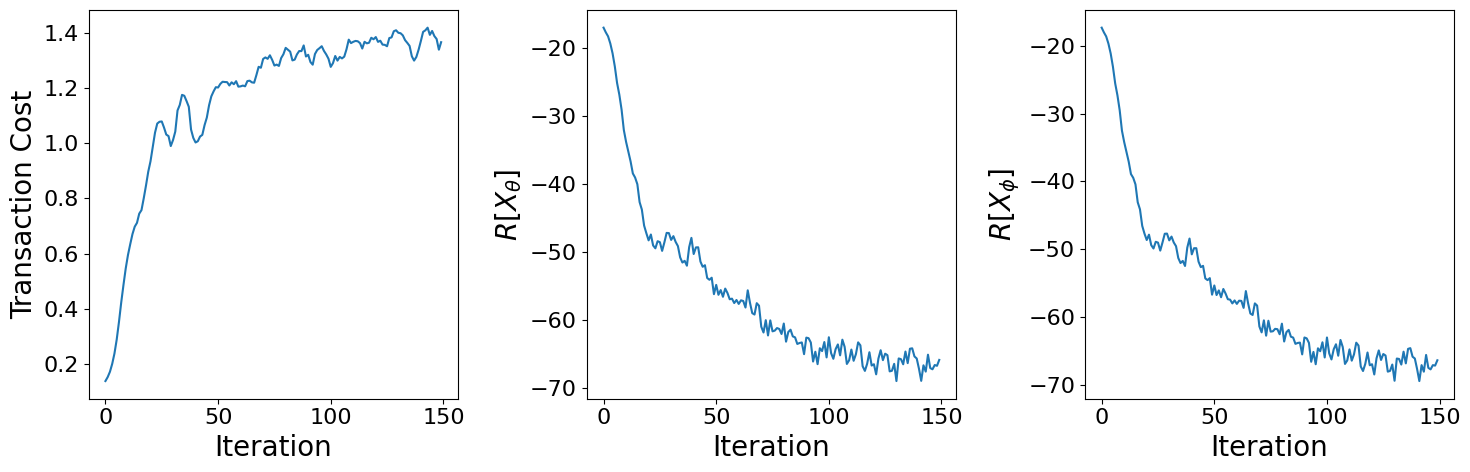

In [ ]:
print("Elapsed Time:", elapsed_time)
wt = agent.wt_history[-1]
print(wt[-1, -1])
agent.PlotHistory()